# Example 05 - Quantum braiding

This example is more complex than the previous notebooks. 
We strongly encourage readers to have a solid understanding of advanced concepts in solid-state physics, superconductivity, and quantum computing to fully grasp the phenomenon discussed here.

## Kitaev Hamiltonian

To simulate quantum braiding – the non-Abelian anyons exchange – we can utilize the Kitaev model, described by the Hamiltonian presented below. 
This model allows us to observe Majorana zero modes, and by employing a special protocol denoted as $\epsilon_i(t)$, we can manipulate the positions of these Majoranas. In this case, we focus on a trijunction, which involves three chains of length $\ell$ connected at a common site $i=0$. 
For instance, when $\ell=3$, we study the following geometry:

```
3 — 2 — 1 — 0 — 4 — 5 — 6
            |
            7
            |
            8
            |
            9
```

The Hamiltonian is defined as follows:

$$
    H(t) = 
        t\sum_{\langle i, j \rangle} \left(a^\dagger_i a_j + \text{h.c.}\right)
    +   \sum_{\langle i, j \rangle} \left( \Delta_{ij} a^\dagger_i a_j^\dagger + \text{h.c.}\right)
    +   \sum_{i=1}^{3\ell + 1} \epsilon_i(t) \, n_i
    +   V\sum_{\langle i, j \rangle} n_i n_j.
$$

Here, $\Delta_{ij} = \Delta e^{-i \varphi_{ij}}$, and we consider $\phi_{ij}$ to be either $0$, $-\tfrac\pi2$, or $+\tfrac\pi2$ for each trijunction subchain. 
By controlling the values of $\epsilon_i(t)$, one can manipulate the boundaries of the topological region, allowing for the movement of the Majorana modes.

For a deeper understanding, you may refer to the following paper:

- A. Więckowski, M. Mierzejewski, M. Kupczyński, *Majorana phase-gate based on the geometric phase*, [Phys. Rev. B 101, 014504 (2020)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.014504).

In [1]:
import pystrel as ps
import numpy as np
import matplotlib.pyplot as plt
import time as sys_time
from datetime import timedelta
from IPython.display import clear_output

## Braiding protocol

Our braiding protocol consists of 6 steps, each of time length $\tau$. 
The figure below provides a schematic representation of how Majoranas are manipulated during the quantum evolution.

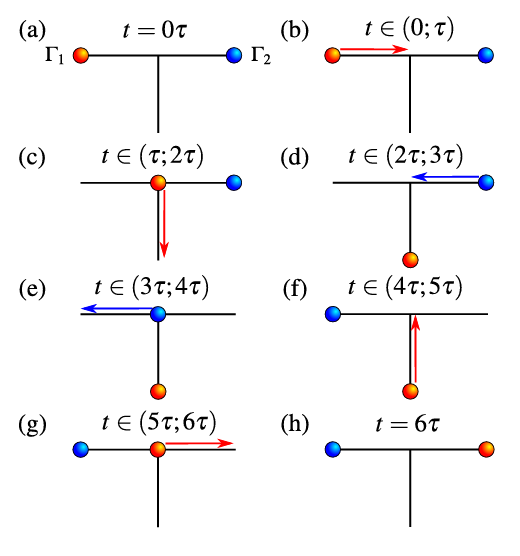

For each step, we employ a smooth ramping protocol described by the following equation

$$
\epsilon_i(t) =\mu + \mu_c \, m[\tfrac t \tau (1 + \alpha (\ell - 1)) - \alpha(\ell - i)],
$$

where $m(x) = \sin^2[\tfrac\pi2 r(x)]$ and $r(x) = \min [\max(x, 0), 1]$.

In [2]:
def build_epsilon(ell, time, *, mu=2.0, tau=10.0, alpha=0.025):
    def ramp(time: float, i: int) -> float:
        x = time / tau * (1 + alpha * (ell - 1)) - alpha * (ell - i)
        r = np.minimum(np.maximum(x, 0.0), 1.0)
        m = np.sin(np.pi / 2.0 * r) ** 2.0
        return m

    def _range(t, t0, t1):
        return np.where((t0 * tau < t) & (t <= t1 * tau), 1.0, 0.0)

    epsilon = {}
    for i in range(ell):
        x = i + 1
        y = x + ell
        z = y + ell
        epsilon[x] = ramp(+time - 0 * tau, i) * _range(time, 0, 3) \
            + ramp(-time + 4 * tau, i) * _range(time, 3, 4)
        epsilon[y] = ramp(+time - 2 * tau, i) * _range(time, 2, 5) \
            + ramp(-time + 6 * tau, i) * _range(time, 5, 6)
        epsilon[z] = ramp(-time + 2 * tau, ell - i) * _range(time, -1, 4) \
            + ramp(+time - 4 * tau, ell - i) * _range(time, 4, 6)
    return {i: mu * v for (i, v) in epsilon.items()}


Except for the coding terms (which are handled by `pystrel`), the braiding protocol is likely the most challenging aspect of this example to implement. 
Below, you can see the plot for $\epsilon_i(t)$ for all sites $i$.

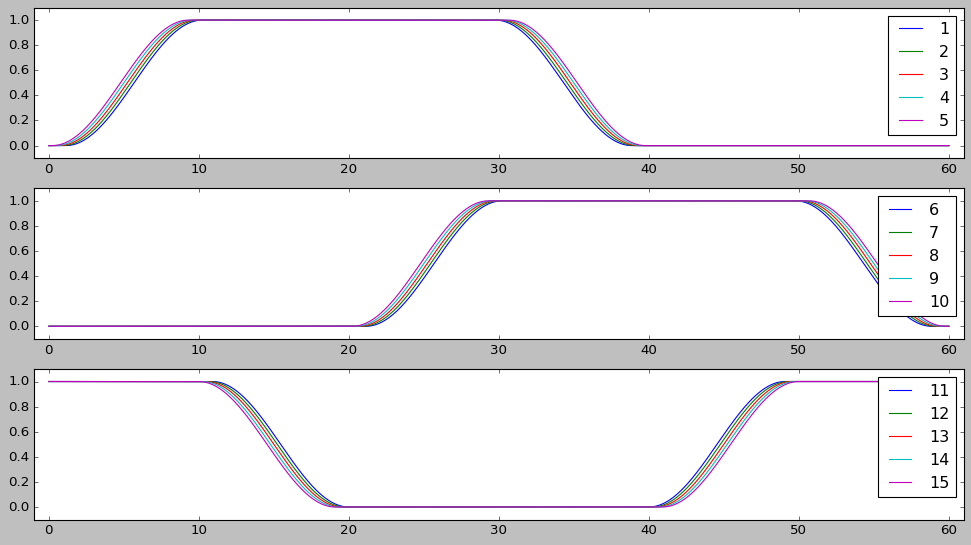

In [3]:
ell = 5
tau = 10.0
time = np.linspace(0, 6*tau, 3413)
epsilons = build_epsilon(ell=ell, time=time, mu=1.0, tau=tau)

plt.style.use("classic")
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 8))
ax = [ax1, ax2, ax3]

for i in range(1, ell + 1):
    ax1.plot(time, epsilons[i + 0 * ell], label=str(i + 0 * ell))
    ax2.plot(time, epsilons[i + 1 * ell], label=str(i + 1 * ell))
    ax3.plot(time, epsilons[i + 2 * ell], label=str(i + 2 * ell))

for i in ax:
    i.set_xlim([-1, +6 * tau + 1])
    i.set_ylim([-0.1, 1.1])
    i.legend()

plt.show()

## Exchange phase

It is well known that during *cyclic* and *adiabatic* evolution for the braiding of the Majorana Zero Modes, there is a Berry phase difference of $\Delta\phi_{\text{Berry}} = \pm\frac\pi2$. This phase change is calculated separately for even and odd parity sectors

$$
    \Delta \phi = \phi_e - \phi_o.
$$

From a numerical standpoint, these geometric phases can be calculated using the following scheme

$$
\phi_{e,o}(T) = \arg\left( \langle\psi(T)|\psi(0)\rangle\prod_{i}^{k:t_k = T} \langle \psi(t_{i}) | \psi(t_{i+1})\rangle \right).
$$

In [4]:
def simulate(*, parity, **kwargs):
    ell = kwargs.get("ell", 2)
    tau = kwargs.get("tau", 100.0)
    dt = kwargs.get("dt", 0.01)
    t = kwargs.get("t", 1.0)
    Delta = kwargs.get("Delta", 1.0)
    L = 3 * ell + 1
    T = 6 * tau

    def build_t(ell):
        return (
            {(i + 0 * ell, i + 1 + 0 * ell): t for i in range(1, ell)}
            | {(i + 1 * ell, i + 1 + 1 * ell): t for i in range(1, ell)}
            | {(i + 2 * ell, i + 1 + 2 * ell): t for i in range(1, ell)}
            | {(0, 1): t, (0, ell + 1): t, (0, 2 * ell + 1): t}
        )

    def build_delta(ell, *, phi=None):
        phi = (
            [np.exp(-1j * 0.0), np.exp(-1j * +0.5 * np.pi), np.exp(-1j * -0.5 * np.pi)]
            if phi is None
            else phi
        )
        phi = np.array(phi)
        phi *= Delta
        return (
            {(i + 0 * ell, i + 1 + 0 * ell): phi[0] for i in range(1, ell)}
            | {(i + 1 * ell, i + 1 + 1 * ell): phi[1] for i in range(1, ell)}
            | {(i + 2 * ell, i + 1 + 2 * ell): phi[2] for i in range(1, ell)}
            | {(0, 1): phi[0], (0, ell + 1): phi[1], (0, 2 * ell + 1): phi[2]}
        )

    params: ps.Parameters = {
        "sites": L,
        "parity": parity,
        "terms": {
            "t": build_t(ell),
            "Delta": build_delta(ell),
            "epsilon": build_epsilon(ell, time=0.0),
        },
    }
    model = ps.Model(params)

    def update(time):
        model.update_terms({"epsilon": build_epsilon(ell, time, tau=tau)})
        return model.build_hamiltonian(dtype=np.complex128)

    def get_ground_state():
        h = model.build_hamiltonian(dtype=np.complex128)
        _, v = ps.spectrum.get_full_spectrum(h)
        return v[0]

    def measure_time(time, clear_time, start_time):
        current_sys_time = sys_time.time()
        if current_sys_time - clear_time > 0.5:
            clear_output(wait=True)
            prct = np.round(time / T * 100, 2)
            elapsed_time = timedelta(seconds=sys_time.time() - start_time)
            remaining_time = (100 - prct) / (prct + 1e-9) * elapsed_time
            print(
                f"{prct}% (elapsed time: {elapsed_time}, remaining time: {remaining_time})"
            )
            clear_time = current_sys_time
        return clear_time

    def propagate(psi):
        start_time = sys_time.time()
        clear_time = 0.0

        time = 0.0
        arg = 1.0 + 0.0j
        psi0 = psi.copy()
        times = []
        phases = []
        while time <= 6 * tau:
            phi = psi.copy()
            psi = ps.propagate(psi, update, time, dt)

            arg *= np.dot(phi.conj(), psi)
            arg0 = np.dot(psi.conj(), psi0)
            phase = np.angle(arg * arg0)

            times.append(time)
            phases.append(phase)

            clear_time = measure_time(time, clear_time, start_time)
            time += dt
        return np.array([times, phases])

    psi = get_ground_state()
    result = propagate(psi)
    return result


In [5]:
result_p0 = simulate(parity=0, tau=100.0)

99.99% (elapsed time: 0:34:47.386154, remaining time: 0:00:00.208759)


In [6]:
result_p1 = simulate(parity=1, tau=100.0)

100.0% (elapsed time: 0:35:34.203447, remaining time: 0:00:00)


As a result, it can be observed that after the exchange, a pair of Majorana Zero Modes accumulates a phase of $\Delta\phi(T) = \frac{\pi}{2}$.

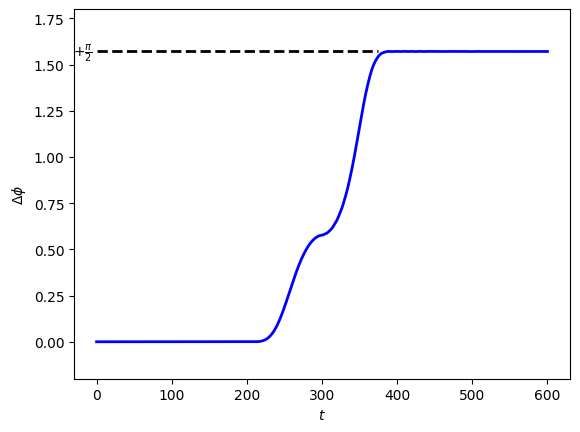

In [21]:
tau = 100.0
time = result_p0[0, :]
dphi = result_p1[1, :] - result_p0[1, :]

plt.style.use("default")
plt.plot(time, dphi, lw=2, color='blue')
plt.plot([0, 3.75*tau], [np.pi / 2] * 2, '--', color='black', lw=2)
plt.ylim([-0.2, 1.8])
plt.xlabel("$t$")
plt.ylabel("$\Delta \phi$")
plt.annotate(r'$+\frac{\pi}{2}$', (0, np.pi/2), textcoords="offset points", xytext=(-10,-3), ha='center')
plt.show()